In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set(style="whitegrid")


In [4]:
# Load historical match data (CSV)
matches = pd.read_csv('/content/results.csv', encoding='ISO-8859-1')
print("Historical matches loaded:", matches.shape)

# Load current standings data (Excel)
standings = pd.read_excel('/content/Points_table_2025.xlsx')
print("Current standings loaded:", standings.shape)

# Load remaining fixtures (CSV) with columns: HomeTeam, AwayTeam
fixtures = pd.read_excel('/content/Matches_left.xlsx')
print("Remaining fixtures loaded:", fixtures.shape)


Historical matches loaded: (6769, 23)
Current standings loaded: (20, 10)
Remaining fixtures loaded: (161, 2)


In [5]:
# Define a mapping to standardize team names (adjust as needed)
name_mapping = {
    'AFC Bournemouth': 'Bournemouth',
    # Add more mappings if needed
}

# Standardize names in historical matches for both HomeTeam and AwayTeam
matches['HomeTeam'] = matches['HomeTeam'].replace(name_mapping)
matches['AwayTeam'] = matches['AwayTeam'].replace(name_mapping)

# Standardize names in fixtures
fixtures['HomeTeam'] = fixtures['HomeTeam'].replace(name_mapping)
fixtures['AwayTeam'] = fixtures['AwayTeam'].replace(name_mapping)

# Also standardize current standings if necessary
standings['Team'] = standings['Team'].replace(name_mapping)


In [6]:
# Build Poisson regression model for home goals
formula_home = 'FTHG ~ C(HomeTeam) + C(AwayTeam)'
poisson_model_home = smf.glm(formula=formula_home, data=matches,
                             family=sm.families.Poisson()).fit()
print("Home Goals Model Summary:")
print(poisson_model_home.summary())

# Build Poisson regression model for away goals
formula_away = 'FTAG ~ C(HomeTeam) + C(AwayTeam)'
poisson_model_away = smf.glm(formula=formula_away, data=matches,
                             family=sm.families.Poisson()).fit()
print("\nAway Goals Model Summary:")
print(poisson_model_away.summary())


Home Goals Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                   FTHG   No. Observations:                 6769
Model:                            GLM   Df Residuals:                     6688
Model Family:                 Poisson   Df Model:                           80
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10222.
Date:                Fri, 07 Feb 2025   Deviance:                       7555.1
Time:                        06:50:40   Pearson chi2:                 6.59e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1338
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------

In [7]:
# Create a sorted list of teams used in training
teams_train = sorted(set(matches['HomeTeam'].unique()).union(set(matches['AwayTeam'].unique())))
print("Teams in training data:")
print(teams_train)


Teams in training data:
['Arsenal', 'Aston Villa', 'Birmingham', 'Blackburn', 'Blackpool', 'Bolton', 'Bournemouth', 'Brentford', 'Brighton', 'Burnley', 'Cardiff', 'Charlton', 'Chelsea', 'Crystal Palace', 'Derby', 'Everton', 'Fulham', 'Huddersfield', 'Hull', 'Leeds', 'Leicester', 'Liverpool', 'Man City', 'Man United', 'Middlesbrough', 'Newcastle', 'Norwich', 'Portsmouth', 'QPR', 'Reading', 'Sheffield United', 'Southampton', 'Stoke', 'Sunderland', 'Swansea', 'Tottenham', 'Watford', 'West Brom', 'West Ham', 'Wigan', 'Wolves']


In [8]:
def simulate_match_model(home_team, away_team, model_home, model_away, teams_train,
                         league_avg_home_goals, league_avg_away_goals):
    """
    Simulate a match using Poisson regression models.

    Parameters:
        home_team (str): Name of the home team.
        away_team (str): Name of the away team.
        model_home: Poisson model for home goals.
        model_away: Poisson model for away goals.
        teams_train (list): List of teams from training data.
        league_avg_home_goals (float): League average home goals.
        league_avg_away_goals (float): League average away goals.

    Returns:
        (int, int): Simulated goals for home and away teams.
    """
    # Create a DataFrame for prediction
    new_data = pd.DataFrame({'HomeTeam': [home_team], 'AwayTeam': [away_team]})

    # Set the categorical levels to match those used in training
    new_data['HomeTeam'] = pd.Categorical(new_data['HomeTeam'], categories=teams_train)
    new_data['AwayTeam'] = pd.Categorical(new_data['AwayTeam'], categories=teams_train)

    # Predict expected goals for the home team
    try:
        lambda_home = model_home.predict(new_data)[0]
        # Check if the predicted value is nan (if team was unknown)
        if np.isnan(lambda_home):
            raise ValueError
    except Exception:
        print(f"Warning: '{home_team}' not found in training data. Using league average for home goals.")
        lambda_home = league_avg_home_goals

    # Predict expected goals for the away team
    try:
        lambda_away = model_away.predict(new_data)[0]
        if np.isnan(lambda_away):
            raise ValueError
    except Exception:
        print(f"Warning: '{away_team}' not found in training data. Using league average for away goals.")
        lambda_away = league_avg_away_goals

    # Simulate match outcome using Poisson random draws
    home_goals = poisson.rvs(mu=lambda_home)
    away_goals = poisson.rvs(mu=lambda_away)

    return home_goals, away_goals


In [9]:
league_avg_home_goals = matches['FTHG'].mean()
league_avg_away_goals = matches['FTAG'].mean()
print("League Average Home Goals:", league_avg_home_goals)
print("League Average Away Goals:", league_avg_away_goals)


League Average Home Goals: 1.5226769094400945
League Average Away Goals: 1.1610282168710298


In [10]:
# Convert current standings DataFrame to a dictionary keyed by team name
standings_dict = {}
for _, row in standings.iterrows():
    team = row['Team']
    standings_dict[team] = {
        'P': int(row['P']),
        'W': int(row['W']),
        'D': int(row['D']),
        'L': int(row['L']),
        'F': int(row['F']),
        'A': int(row['A']),
        'GD': int(row['GD']),
        'Points': int(row['Points'])
    }

def update_standings(standings_dict, home_team, away_team, home_goals, away_goals):
    """
    Update the standings dictionary with the result of one match.
    """
    # Update matches played
    standings_dict[home_team]['P'] += 1
    standings_dict[away_team]['P'] += 1

    # Update goals for and against
    standings_dict[home_team]['F'] += home_goals
    standings_dict[home_team]['A'] += away_goals
    standings_dict[away_team]['F'] += away_goals
    standings_dict[away_team]['A'] += home_goals

    # Recalculate goal difference
    standings_dict[home_team]['GD'] = standings_dict[home_team]['F'] - standings_dict[home_team]['A']
    standings_dict[away_team]['GD'] = standings_dict[away_team]['F'] - standings_dict[away_team]['A']

    # Update wins, draws, losses, and points
    if home_goals > away_goals:
        standings_dict[home_team]['W'] += 1
        standings_dict[away_team]['L'] += 1
        standings_dict[home_team]['Points'] += 3
    elif home_goals < away_goals:
        standings_dict[away_team]['W'] += 1
        standings_dict[home_team]['L'] += 1
        standings_dict[away_team]['Points'] += 3
    else:
        standings_dict[home_team]['D'] += 1
        standings_dict[away_team]['D'] += 1
        standings_dict[home_team]['Points'] += 1
        standings_dict[away_team]['Points'] += 1

    return standings_dict


In [11]:
# List to store simulated match results (using the model)
simulation_results_model = []

for idx, match in fixtures.iterrows():
    home_team = match['HomeTeam']
    away_team = match['AwayTeam']

    # Simulate the match result using our model function
    home_goals, away_goals = simulate_match_model(home_team, away_team,
                                                    poisson_model_home, poisson_model_away,
                                                    teams_train, league_avg_home_goals, league_avg_away_goals)

    simulation_results_model.append({
        'HomeTeam': home_team,
        'AwayTeam': away_team,
        'HomeGoals': home_goals,
        'AwayGoals': away_goals
    })

    # Update standings if both teams exist
    if home_team in standings_dict and away_team in standings_dict:
        standings_dict = update_standings(standings_dict, home_team, away_team, home_goals, away_goals)
    else:
        print(f"Warning: One of the teams ({home_team} or {away_team}) not found in standings.")

# Create a DataFrame of simulated match results
results_df_model = pd.DataFrame(simulation_results_model)
print("Simulated Match Results Using the Poisson Regression Model:")
print(results_df_model)


Simulated Match Results Using the Poisson Regression Model:
              HomeTeam           AwayTeam  HomeGoals  AwayGoals
0          Bournemouth  Nottingham Forest          2          1
1             Brighton            Everton          1          1
2            Liverpool       Ipswich Town          2          1
3          Southampton          Newcastle          4          5
4               Wolves            Arsenal          1          2
..                 ...                ...        ...        ...
156   Newcastle United            Everton          3          1
157  Nottingham Forest            Chelsea          1          2
158        Southampton            Arsenal          0          3
159              Spurs           Brighton          2          1
160             Wolves          Brentford          0          3

[161 rows x 4 columns]



Predicted League Standings (Model-Based Simulation):
    Rank               Team   P   W   D   L   F   A  GD  Points
1      1          Liverpool  38  26   7   5  84  40  44      85
2      2            Arsenal  38  22  10   6  78  41  37      76
3      3           Man City  38  20   6  12  64  44  20      66
4      4  Nottingham Forest  38  19   7  12  55  44  11      64
5      5            Chelsea  38  18   9  11  67  51  16      63
6      6   Newcastle United  37  17   8  12  57  48   9      59
7      7        Aston Villa  38  16   9  13  58  58   0      57
8      8           Brighton  38  14  14  10  51  48   3      56
9      9     Crystal Palace  38  13  15  10  44  40   4      54
10    10        Bournemouth  38  13  10  15  51  58  -7      49
11    11           West Ham  38  14   7  17  49  70 -21      49
12    12            Man Utd  38  12  12  14  49  50  -1      48
13    13             Fulham  38  12  12  14  54  58  -4      48
14    14          Brentford  38  13   8  17  59  6

<ipython-input-12-bb47b394bb7b>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Points', y='Team', data=predicted_standings_model, palette='viridis')


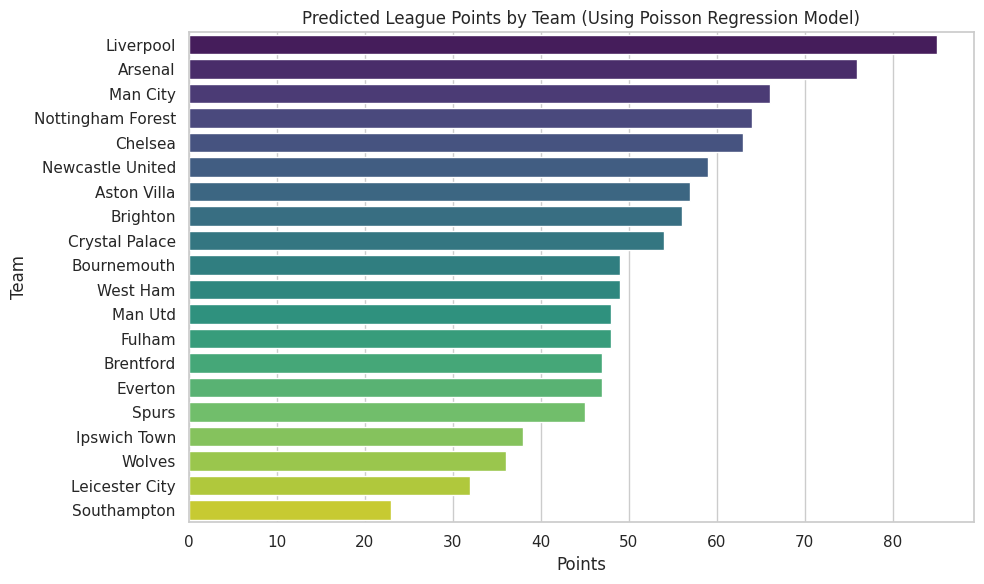

In [12]:
# Convert standings dictionary back to DataFrame
predicted_standings_model = pd.DataFrame.from_dict(standings_dict, orient='index').reset_index().rename(columns={'index': 'Team'})

# Sort standings: first by Points, then Goal Difference, then Goals For
predicted_standings_model = predicted_standings_model.sort_values(by=['Points', 'GD', 'F'], ascending=False).reset_index(drop=True)
predicted_standings_model.index += 1  # Ranking starts at 1
predicted_standings_model.insert(0, 'Rank', predicted_standings_model.index)

print("\nPredicted League Standings (Model-Based Simulation):")
print(predicted_standings_model)

# Visualize predicted points for each team
plt.figure(figsize=(10, 6))
sns.barplot(x='Points', y='Team', data=predicted_standings_model, palette='viridis')
plt.title("Predicted League Points by Team (Using Poisson Regression Model)")
plt.xlabel("Points")
plt.ylabel("Team")
plt.tight_layout()
plt.show()
